In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import pingouin as pg
import seaborn as sns
sns.set(context='notebook', style='whitegrid', palette='Set2', font='sans-serif',
       font_scale=1.2, color_codes=True, rc={'figure.figsize':(20.7,20.27)})
%matplotlib inline

In [2]:
adni = pd.read_csv('../database_split/database_info/ADNI_experiment_information.csv')
adni = adni[['Subject ID', 'Research Group', 'MMSE Total Score', 'Visit']]
adni['Image Filename'] = adni[['Subject ID', 'Visit']].apply(lambda x: x[0]+'_'+x[1].replace(' ', '_').replace('/', ''), axis=1)
print(adni.shape)
adni.head()

(762, 5)


,Subject ID,Research Group,MMSE Total Score,Visit,Image Filename
0,002_S_0619,AD,22,ADNI Screening,002_S_0619_ADNI_Screening
1,002_S_0938,AD,23,ADNI Screening,002_S_0938_ADNI_Screening
2,002_S_0955,AD,21,ADNI Screening,002_S_0955_ADNI_Screening
3,002_S_5018,AD,24,ADNI2 Month 6-New Pt,002_S_5018_ADNI2_Month_6-New_Pt
4,003_S_1059,AD,25,ADNI Screening,003_S_1059_ADNI_Screening


In [3]:
cn = pd.read_csv('../predict_results/test_70-100_LR_holds.csv', sep=',')
cn['Research Group'] = 'CN'
ad = pd.read_csv('../predict_results/ad_70-100_LR_holds.csv', sep=',')
ad['Research Group'] = 'AD'
mci= pd.read_csv('../predict_results/mci_70-100_LR_holds.csv', sep=',')
mci['Research Group'] = 'MCI'
results = pd.concat([cn, ad, mci]).reset_index(drop=True)
# results=cn
results = results[['Name', 'True', 'Pred', 'Research Group']]
results.columns = ['Image Filename', 'Chronological age', 'Estimated age', 'Research Group']
print(results.shape)
results.head()

/home/kpoloni/.local/lib/python3.6/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.11, the latest is 0.4.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


(762, 4)


,Image Filename,Chronological age,Estimated age,Research Group
0,023_S_4164_ADNI2_Month_6-New_Pt,73.6,78.10059,CN
1,014_S_4093_ADNI2_Month_6-New_Pt,70.6,76.46625,CN
2,021_S_0647_ADNI_Screening,72.9,74.11468,CN
3,019_S_4835_ADNI2_Year_1_Visit,80.4,75.64610,CN
4,022_S_4320_ADNI2_Month_6-New_Pt,71.5,76.68798,CN


In [4]:
data = adni.merge(results, on=['Image Filename', 'Research Group']).reset_index(drop=True)
data.columns = ['Subject ID', 'group', 'MMSE', 'Visit', 'Image Filename','Chronological age', 'Estimated age']
data['Delta'] = data[['Chronological age', 'Estimated age']].apply(lambda x: x['Estimated age'] - x['Chronological age'], axis=1)
data.shape


(762, 8)

           n         r           CI95%        r2    adj_r2         p-val  \
pearson  762 -0.313693  [-0.38, -0.25]  0.098404  0.096028  7.319018e-19   

            BF10  power  
pearson  5.1e+15    1.0  
linear relationship


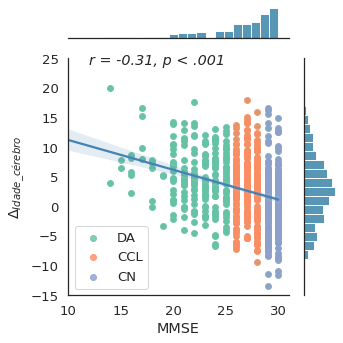

In [6]:
# Pt-br
sns.set(context='notebook', style='white', palette='Set2', font='sans-serif',
        font_scale=1.2, color_codes=True, rc={'figure.figsize': (20.7, 20.27)})
pearson = pg.corr(data.MMSE, data.Delta)
print(pearson)
print("linear relationship" if pearson['p-val']
      [0] < 0.001 else "not linear relationship")

dt = data[['Delta', 'group', 'MMSE']]
dt.columns = [r'$\Delta_{Idade\_cérebro}$', 'group', 'MMSE']

g = sns.jointplot(data=dt, x='MMSE', y=r'$\Delta_{Idade\_cérebro}$', xlim=(
    10, 31), ylim=(-15, 25), height=5)
g = g.plot_marginals(sns.histplot, color="steelblue")

pt_gr = ['DA', 'CCL', 'CN']
for i, group in enumerate(['AD', 'MCI', 'CN']):
    gr = dt[dt.group == group]
    ax = sns.regplot(x='MMSE', y=r'$\Delta_{Idade\_cérebro}$', data=gr,
                     scatter=True, ax=g.ax_joint, truncate=False, fit_reg=False, label=pt_gr[i])
    ax.set_label('Label via method')
    ax.legend()

sns.regplot(x='MMSE', y=r'$\Delta_{Idade\_cérebro}$', data=dt,
            scatter=False, ax=g.ax_joint, color="steelblue")
g.ax_joint.text(12, 24, 'r = ' +
                str(pearson.r[0].round(2)) + ', p < .001', fontstyle='italic')

#g.set_axis_labels('Idade cronológica', 'Idade estimada')

plt.tight_layout()
plt.savefig("mmse_delta_LR_pt.pdf", bbox_inches='tight', dpi=300)



           n         r           CI95%        r2    adj_r2         p-val  \
pearson  762 -0.313693  [-0.38, -0.25]  0.098404  0.096028  7.319018e-19   

            BF10  power  
pearson  5.1e+15    1.0  
linear relationship


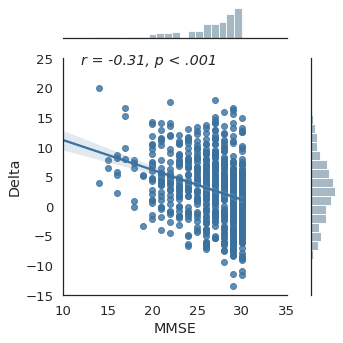

In [8]:

sns.set(style='white', font_scale=1.2)
pearson = pg.corr(data.MMSE, data.Delta)
print(pearson)
print("linear relationship" if pearson['p-val'][0]<0.001 else "not linear relationship")
g = sns.JointGrid(data=data, x='MMSE', y='Delta', xlim=(10, 35), ylim=(-15, 25), height=5)
g.plot_joint(sns.regplot, color="xkcd:muted blue")
g = g.plot_marginals(sns.histplot, color="xkcd:bluey grey")
g.ax_joint.text(12, 24, 'r = ' + str(pearson.r[0].round(2)) + ', p < .001', fontstyle='italic')
plt.tight_layout()
plt.savefig("mmse_delta_LR.pdf", bbox_inches='tight')

           n         r           CI95%        r2    adj_r2         p-val  \
pearson  762 -0.313693  [-0.38, -0.25]  0.098404  0.096028  7.319018e-19   

            BF10  power  
pearson  5.1e+15    1.0  
linear relationship


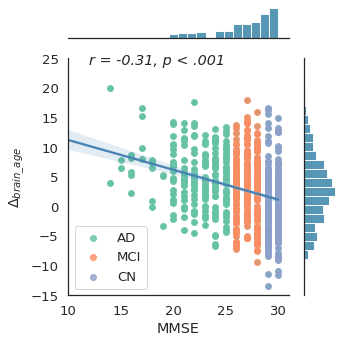

In [49]:
sns.set(context='notebook', style='white', palette='Set2', font='sans-serif',
       font_scale=1.2, color_codes=True, rc={'figure.figsize':(20.7,20.27)})
pearson = pg.corr(data.MMSE, data.Delta)
print(pearson)
print("linear relationship" if pearson['p-val'][0]<0.001 else "not linear relationship")

dt = data[['Delta', 'group', 'MMSE']]
dt.columns = [r'$\Delta_{ brain\_age}$', 'group', 'MMSE']

g = sns.jointplot(data=dt, x='MMSE', y=r'$\Delta_{ brain\_age}$', xlim=(10, 31), ylim=(-15, 25), height=5)
g = g.plot_marginals(sns.histplot, color="steelblue")

for group in ['AD', 'MCI', 'CN']:
    gr = dt[dt.group == group]
    ax = sns.regplot(x='MMSE', y=r'$\Delta_{ brain\_age}$', data=gr, scatter=True, ax=g.ax_joint, truncate=False, fit_reg=False, label=group)
    ax.set_label('Label via method')
    ax.legend()

sns.regplot(x='MMSE', y=r'$\Delta_{ brain\_age}$', data=dt, scatter=False, ax=g.ax_joint, color="steelblue")
g.ax_joint.text(12, 24, 'r = ' + str(pearson.r[0].round(2)) + ', p < .001', fontstyle='italic')


plt.tight_layout()
plt.savefig("mmse_delta_LR.pdf", bbox_inches='tight', dpi=300)

In [10]:
data

,Subject ID,group,MMSE,Visit,Image Filename,Chronological age,Estimated age,Delta
0,002_S_0619,AD,22,ADNI Screening,002_S_0619_ADNI_Screening,77.6,82.164370,4.564370
1,002_S_0938,AD,23,ADNI Screening,002_S_0938_ADNI_Screening,82.3,80.625818,-1.674182
2,002_S_0955,AD,21,ADNI Screening,002_S_0955_ADNI_Screening,78.3,80.692521,2.392521
3,002_S_5018,AD,24,ADNI2 Month 6-New Pt,002_S_5018_ADNI2_Month_6-New_Pt,73.9,72.733935,-1.166065
4,003_S_1059,AD,25,ADNI Screening,003_S_1059_ADNI_Screening,84.6,89.115598,4.515598
...,...,...,...,...,...,...,...,...
757,141_S_1231,MCI,26,ADNI Screening,141_S_1231_ADNI_Screening,83.7,87.798286,4.098286
758,141_S_1245,MCI,27,ADNI Screening,141_S_1245_ADNI_Screening,71.4,78.095350,6.695350
759,141_S_1255,MCI,28,ADNI Screening,141_S_1255_ADNI_Screening,76.6,86.543492,9.943493
760,941_S_1295,MCI,28,ADNI Screening,941_S_1295_ADNI_Screening,76.8,87.975205,11.175205


,n,r,CI95%,r2,adj_r2,p-val,BF10,power
pearson,42,0.954612,"[0.92, 0.98]",0.911284,0.906734,1.195126e-22,2.07e+19,1.0


True


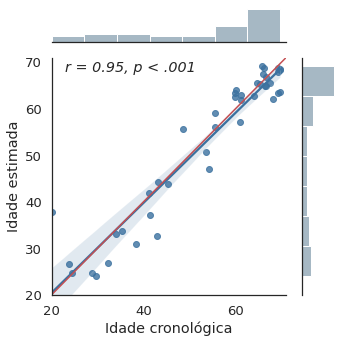

In [15]:
# pt
sns.set(context='notebook', style='white', palette='Set2', font='sans-serif',
       font_scale=1.2, color_codes=True, rc={'figure.figsize':(20.7,20.27)})
       
val = pd.read_csv('../predict_results/test_0-70_LR.csv', sep=',')
val['Research Group'] = 'CN'
val = val[['Name', 'True', 'Pred', 'Research Group']]
val.columns = ['Image Filename', 'Chronological age', 'Estimated age', 'Research Group']

pearson = pg.corr(val['Estimated age'], val['Chronological age'])
display(pearson)
print(pearson['p-val'][0]<0.001)

sns.set(style='white', font_scale=1.2)
g = sns.JointGrid(data=val, x='Chronological age', y='Estimated age',
                  xlim=(20, 71), ylim=(20, 71), height=5)
g.plot_joint(sns.regplot, color="xkcd:muted blue")
g = g.plot_marginals(sns.histplot, color="xkcd:bluey grey")
g.ax_joint.text(23, 68, 'r = ' + str(pearson.r[0].round(2)) + ', p < .001', fontstyle='italic')
x0, x1 = g.ax_joint.get_xlim()
y0, y1 = g.ax_joint.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
g.ax_joint.plot(lims, lims, '-r')
g.set_axis_labels('Idade cronológica', 'Idade estimada')
plt.tight_layout()
plt.savefig("correlation_0-70_LR_pt.pdf", bbox_inches='tight', dpi=300)


,n,r,CI95%,r2,adj_r2,p-val,BF10,power
pearson,42,0.927498,"[0.87, 0.96]",0.860253,0.853086,1.086660e-18,3.662e+15,1.0


linear relationship


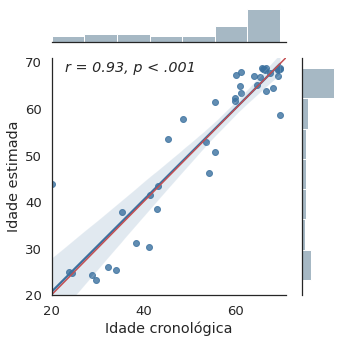

In [16]:
val = pd.read_csv('../predict_results/test_0-70_L.csv', sep=',')
val['Research Group'] = 'CN'
val = val[['Name', 'True', 'Pred', 'Research Group']]
val.columns = ['Image Filename', 'Chronological age',
               'Estimated age', 'Research Group']

pearson = pg.corr(val['Estimated age'],
                  val['Chronological age'], tail='two-sided')
display(pearson)
print("linear relationship" if pearson['p-val'][0] < 0.01 else "")
sns.set(style='white', font_scale=1.2)
g = sns.JointGrid(data=val, x='Chronological age', y='Estimated age',
                  xlim=(20, 71), ylim=(20, 71), height=5)
g.plot_joint(sns.regplot, color="xkcd:muted blue")
g = g.plot_marginals(sns.histplot, color="xkcd:bluey grey")
g.ax_joint.text(23, 68, 'r = ' +
                str(pearson.r[0].round(2)) + ', p < .001', fontstyle='italic')
x0, x1 = g.ax_joint.get_xlim()
y0, y1 = g.ax_joint.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
g.ax_joint.plot(lims, lims, '-r')
g.set_axis_labels('Idade cronológica', 'Idade estimada')
plt.tight_layout()
plt.savefig("correlation_0-70_L.pdf", bbox_inches='tight', dpi=300)


,n,r,CI95%,r2,adj_r2,p-val,BF10,power
pearson,42,0.92594,"[0.87, 0.96]",0.857365,0.850051,1.638355e-18,2.482e+15,1.0


linear relationship


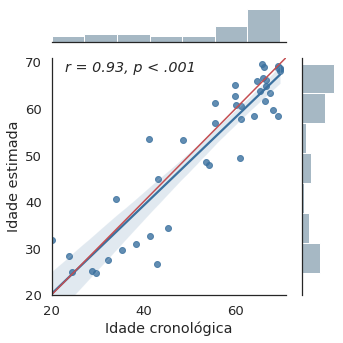

In [20]:
val = pd.read_csv('../predict_results/test_0-70_R.csv', sep=',')
val['Research Group'] = 'CN'
val = val[['Name', 'True', 'Pred', 'Research Group']]
val.columns = ['Image Filename', 'Chronological age',
               'Estimated age', 'Research Group']

pearson = pg.corr(val['Estimated age'], val['Chronological age'])
display(pearson)
print("linear relationship" if pearson['p-val']
      [0] < 0.001 else "not linear relationship")
sns.set(style='white', font_scale=1.2)
g = sns.JointGrid(data=val, x='Chronological age', y='Estimated age',
                  xlim=(20, 71), ylim=(20, 71), height=5)
g.plot_joint(sns.regplot, color="xkcd:muted blue")
g = g.plot_marginals(sns.histplot, color="xkcd:bluey grey")
g.ax_joint.text(23, 68, 'r = ' +
                str(pearson.r[0].round(2)) + ', p < .001', fontstyle='italic')
x0, x1 = g.ax_joint.get_xlim()
y0, y1 = g.ax_joint.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
g.ax_joint.plot(lims, lims, '-r')
g.set_axis_labels('Idade cronológica', 'Idade estimada')
plt.tight_layout()
plt.savefig("correlation_0-70_R_pt.pdf", bbox_inches='tight', dpi=300)


,n,r,CI95%,r2,adj_r2,p-val,BF10,power
pearson,42,0.954612,"[0.92, 0.98]",0.911284,0.906734,1.195126e-22,2.07e+19,1.0


True


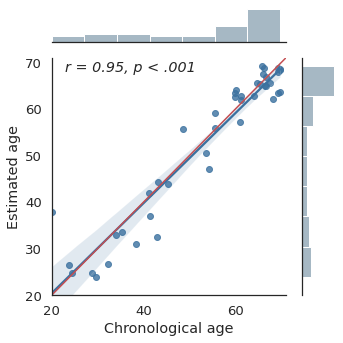

In [14]:
sns.set(context='notebook', style='white', palette='Set2', font='sans-serif',
       font_scale=1.2, color_codes=True, rc={'figure.figsize':(20.7,20.27)})
       
val = pd.read_csv('../predict_results/test_0-70_LR.csv', sep=',')
val['Research Group'] = 'CN'
val = val[['Name', 'True', 'Pred', 'Research Group']]
val.columns = ['Image Filename', 'Chronological age', 'Estimated age', 'Research Group']

pearson = pg.corr(val['Estimated age'], val['Chronological age'])
display(pearson)
print(pearson['p-val'][0]<0.001)

sns.set(style='white', font_scale=1.2)
g = sns.JointGrid(data=val, x='Chronological age', y='Estimated age',
                  xlim=(20, 71), ylim=(20, 71), height=5)
g.plot_joint(sns.regplot, color="xkcd:muted blue")
g = g.plot_marginals(sns.histplot, color="xkcd:bluey grey")
g.ax_joint.text(23, 68, 'r = ' + str(pearson.r[0].round(2)) + ', p < .001', fontstyle='italic')
x0, x1 = g.ax_joint.get_xlim()
y0, y1 = g.ax_joint.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
g.ax_joint.plot(lims, lims, '-r')
plt.tight_layout()
plt.savefig("correlation_0-70_LR.pdf", bbox_inches='tight', dpi=300)

,n,r,CI95%,r2,adj_r2,p-val,BF10,power
pearson,42,0.927498,"[0.87, 0.96]",0.860253,0.853086,1.086660e-18,3.662e+15,1.0


linear relationship


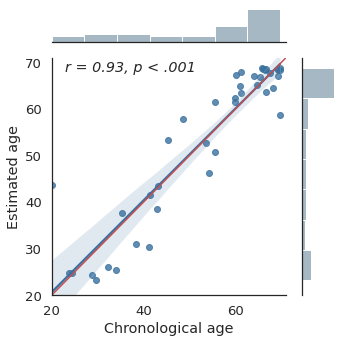

In [17]:
val = pd.read_csv('../predict_results/test_0-70_L.csv', sep=',')
val['Research Group'] = 'CN'
val = val[['Name', 'True', 'Pred', 'Research Group']]
val.columns = ['Image Filename', 'Chronological age', 'Estimated age', 'Research Group']

pearson = pg.corr(val['Estimated age'], val['Chronological age'], tail='two-sided')
display(pearson)
print("linear relationship" if pearson['p-val'][0] < 0.01 else "")
sns.set(style='white', font_scale=1.2)
g = sns.JointGrid(data=val, x='Chronological age', y='Estimated age',
                  xlim=(20, 71), ylim=(20, 71), height=5)
g.plot_joint(sns.regplot, color="xkcd:muted blue")
g = g.plot_marginals(sns.histplot, color="xkcd:bluey grey")
g.ax_joint.text(23, 68, 'r = ' + str(pearson.r[0].round(2)) + ', p < .001', fontstyle='italic')
x0, x1 = g.ax_joint.get_xlim()
y0, y1 = g.ax_joint.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
g.ax_joint.plot(lims, lims, '-r')
plt.tight_layout()
plt.savefig("correlation_0-70_L.pdf", bbox_inches='tight', dpi=300)

,n,r,CI95%,r2,adj_r2,p-val,BF10,power
pearson,42,0.92594,"[0.87, 0.96]",0.857365,0.850051,1.638355e-18,2.482e+15,1.0


linear relationship


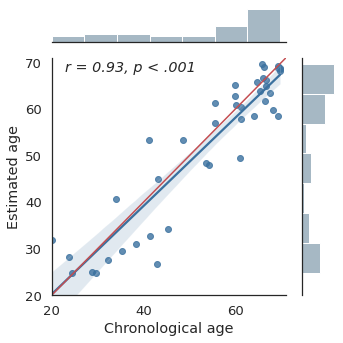

In [18]:
val = pd.read_csv('../predict_results/test_0-70_R.csv', sep=',')
val['Research Group'] = 'CN'
val = val[['Name', 'True', 'Pred', 'Research Group']]
val.columns = ['Image Filename', 'Chronological age', 'Estimated age', 'Research Group']

pearson = pg.corr(val['Estimated age'], val['Chronological age'])
display(pearson)
print("linear relationship" if pearson['p-val'][0]<0.001 else "not linear relationship")
sns.set(style='white', font_scale=1.2)
g = sns.JointGrid(data=val, x='Chronological age', y='Estimated age',
                  xlim=(20, 71), ylim=(20, 71), height=5)
g.plot_joint(sns.regplot, color="xkcd:muted blue")
g = g.plot_marginals(sns.histplot, color="xkcd:bluey grey")
g.ax_joint.text(23, 68, 'r = ' + str(pearson.r[0].round(2)) + ', p < .001', fontstyle='italic')
x0, x1 = g.ax_joint.get_xlim()
y0, y1 = g.ax_joint.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
g.ax_joint.plot(lims, lims, '-r')
plt.tight_layout()
plt.savefig("correlation_0-70_R.pdf", bbox_inches='tight', dpi=300)

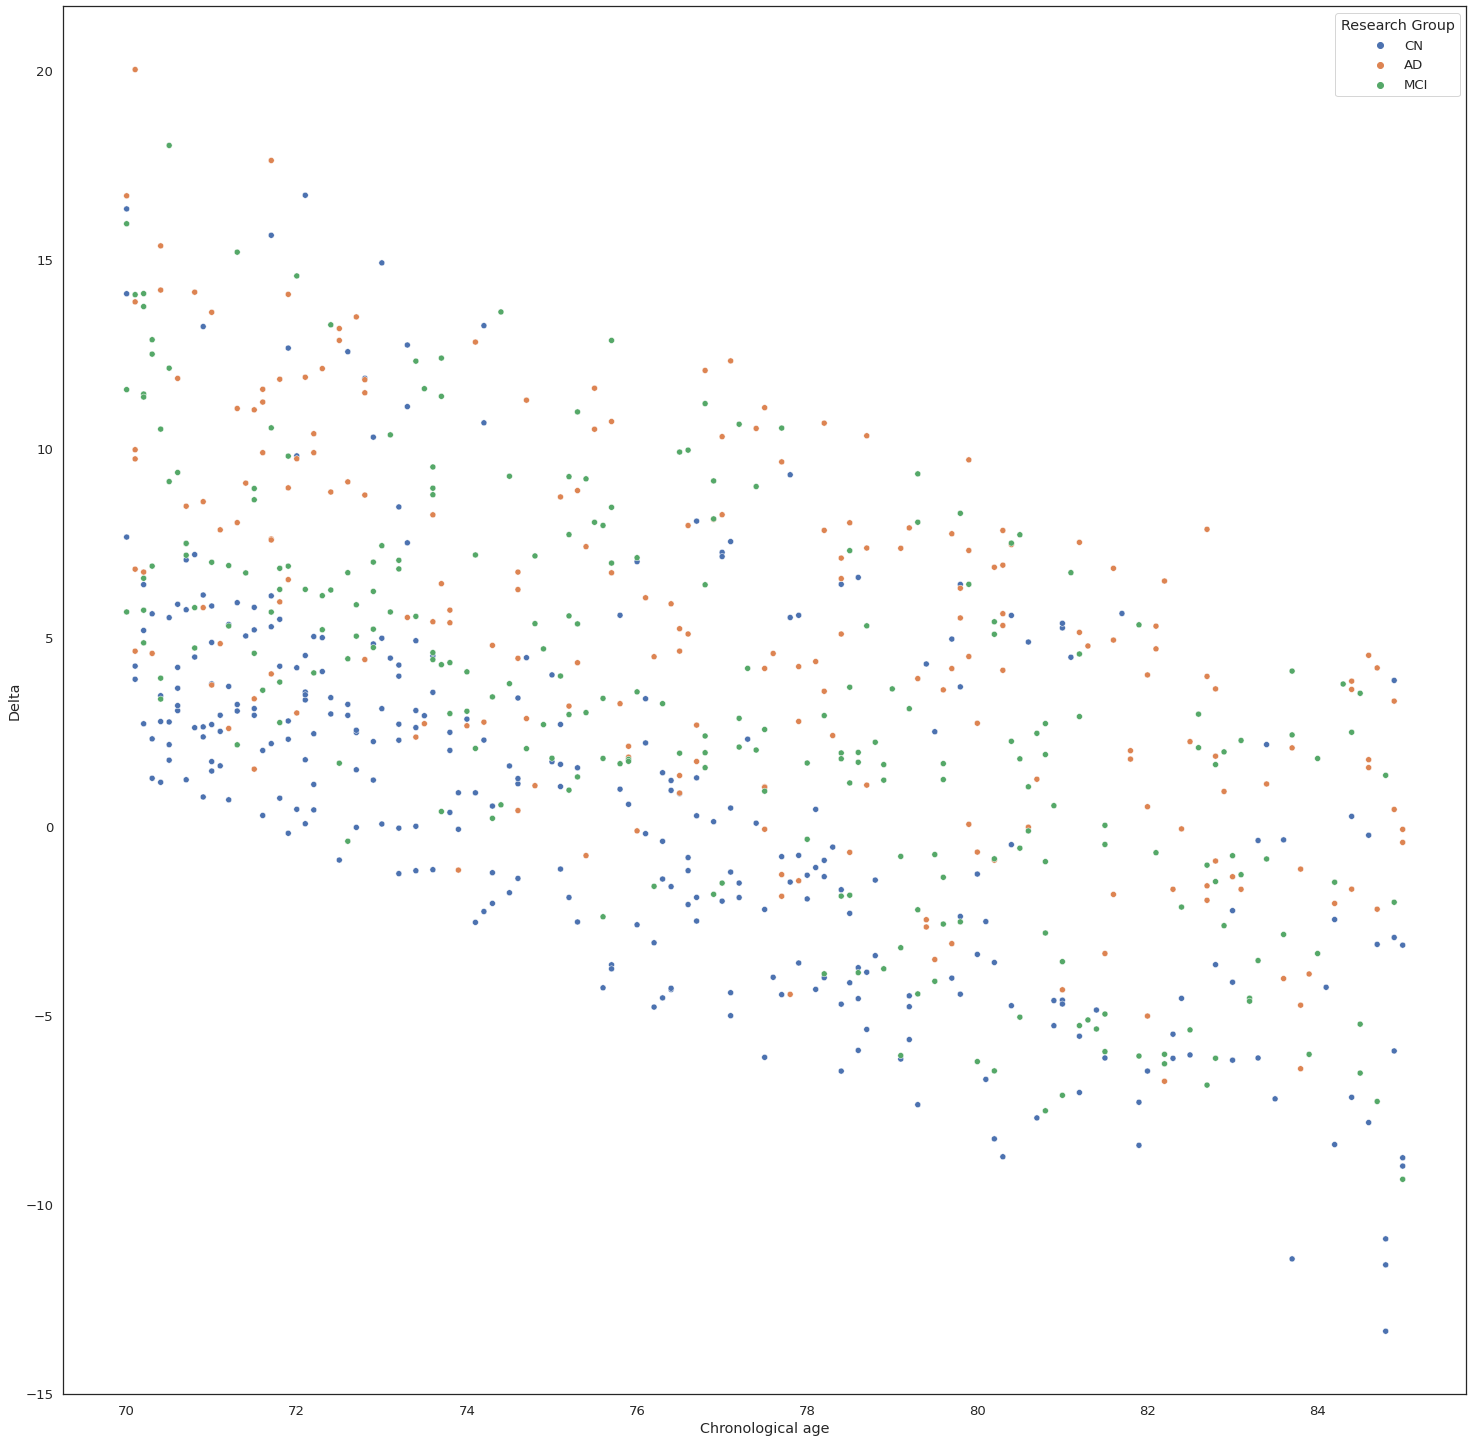

In [19]:
delim = '_holds'
# delim = ''
cn = pd.read_csv('../predict_results/test_70-100_LR' + delim + '.csv', sep=',')
cn['Research Group'] = 'CN'
# cnv = pd.read_csv('../predict_results/val_70-100_LR_bias.csv', sep=',')
# cnv['Research Group'] = 'CN'
ad = pd.read_csv('../predict_results/ad_70-100_LR' + delim + '.csv', sep=',')
ad['Research Group'] = 'AD'
mci= pd.read_csv('../predict_results/mci_70-100_LR' + delim + '.csv', sep=',')
mci['Research Group'] = 'MCI'
results = pd.concat([cn, ad, mci]).reset_index(drop=True)
results = results[['Name', 'True', 'Pred', 'Research Group']]


val =  results
val = val[['Name', 'True', 'Pred', 'Research Group']]
val['Delta'] = val[['True', 'Pred']].apply(lambda x: x[1]-x[0], axis=1)
# val.head()
val.columns = ['Image Filename', 'Chronological age', 'Estimated age', 'Research Group', 'Delta']

sns.set(style='white', font_scale=1.2)
g = sns.scatterplot(data=val, x='Chronological age', y='Delta', hue='Research Group')
plt.tight_layout()
# plt.savefig("correlation_0-70_LR.pdf", bbox_inches='tight', dpi=300)